In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Cleaning

In [131]:
df = pd.read_csv(r'data\DataCoSupplyChainDataset.csv', encoding='unicode_escape')
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [133]:
#size and features of data
def data_info(data):
    print('Number of columns are : ',data.shape[1])
    print('Number of rows are : ',data.shape[0])
    print('Total number of data-points :',data.size)
    numerical_features = [f for f in data.columns if data[f].dtypes!='O']
    print('Count of Numerical Features :',len(numerical_features))
    cat_features = [c for c in data.columns if data[c].dtypes=='O']
    print('Count of Categorical Features :',len(cat_features))
data_info(df)

Number of columns are :  53
Number of rows are :  180519
Total number of data-points : 9567507
Count of Numerical Features : 29
Count of Categorical Features : 24


In [134]:
# Missing values identification
def features_with_missing_values(data):
    for i in data.columns:
        if data[i].isna().sum()>0:
            print(i,'has '+ str(data[i].isna().sum()) + ' missing values')
            
features_with_missing_values(df)

Customer Lname has 8 missing values
Customer Zipcode has 3 missing values
Order Zipcode has 155679 missing values
Product Description has 180519 missing values


We can observe that more than 85% of the values of the features Order Zipcode and Product Description are Null. So, we can drop them.

In [135]:
# Dropping Zipcode and Description
df.drop(['Order Zipcode', 'Product Description'], axis=1, inplace=True)

In [136]:
#dropping product image as it is not required for our data analysis
df = df.drop(['Product Image'], axis=1)

Features without Variance:
Columns without any variance can be excluded. Columns like Customer Email and password have been redacted. Such columns can be dropped.

In [137]:
def check_variance(data, log=False):
    num_variance_cols = []
    for i in data.dtypes.index:
        number_unique = len(data[i].value_counts())
        if number_unique == 1:
            print(i, "Unique Value: {}".format(data[i].value_counts().index[0]))
            num_variance_cols.append(i)
    if log:
        return num_variance_cols, {"No variability in attribute(s):": num_variance_cols}
    else:            
        return num_variance_cols

num_variance_cols, variance_log = check_variance(df, log=True)

Customer Email Unique Value: XXXXXXXXX
Customer Password Unique Value: XXXXXXXXX
Product Status Unique Value: 0


In [138]:
df.drop(['Customer Email', 'Customer Password', 'Product Status'], axis=1, inplace=True)

There are few columns with same data like Order Customer Id and Customer Id. We can check and remove such redundant columns.

In [139]:
from itertools import combinations
def check_redundancies(data):
    redundancy_list = []
    for i in list(combinations(data.columns, 2)):
        if all(data[i[0]] == data[i[1]]):
            redundancy_list.append(i)
            print("{} and {} are the same".format(*i))
    return redundancy_list
redundancies = check_redundancies(df)

Benefit per order and Order Profit Per Order are the same
Sales per customer and Order Item Total are the same
Category Id and Product Category Id are the same
Customer Id and Order Customer Id are the same
Order Item Cardprod Id and Product Card Id are the same
Order Item Product Price and Product Price are the same


In [140]:
#Dropping redundant columns
to_drop =[]
for i in redundancies:
    if len(i[0]) < len(i[1]):
        to_drop.append(i[1])
    else:
        to_drop.append(i[0])

df.drop(columns = to_drop, inplace = True)

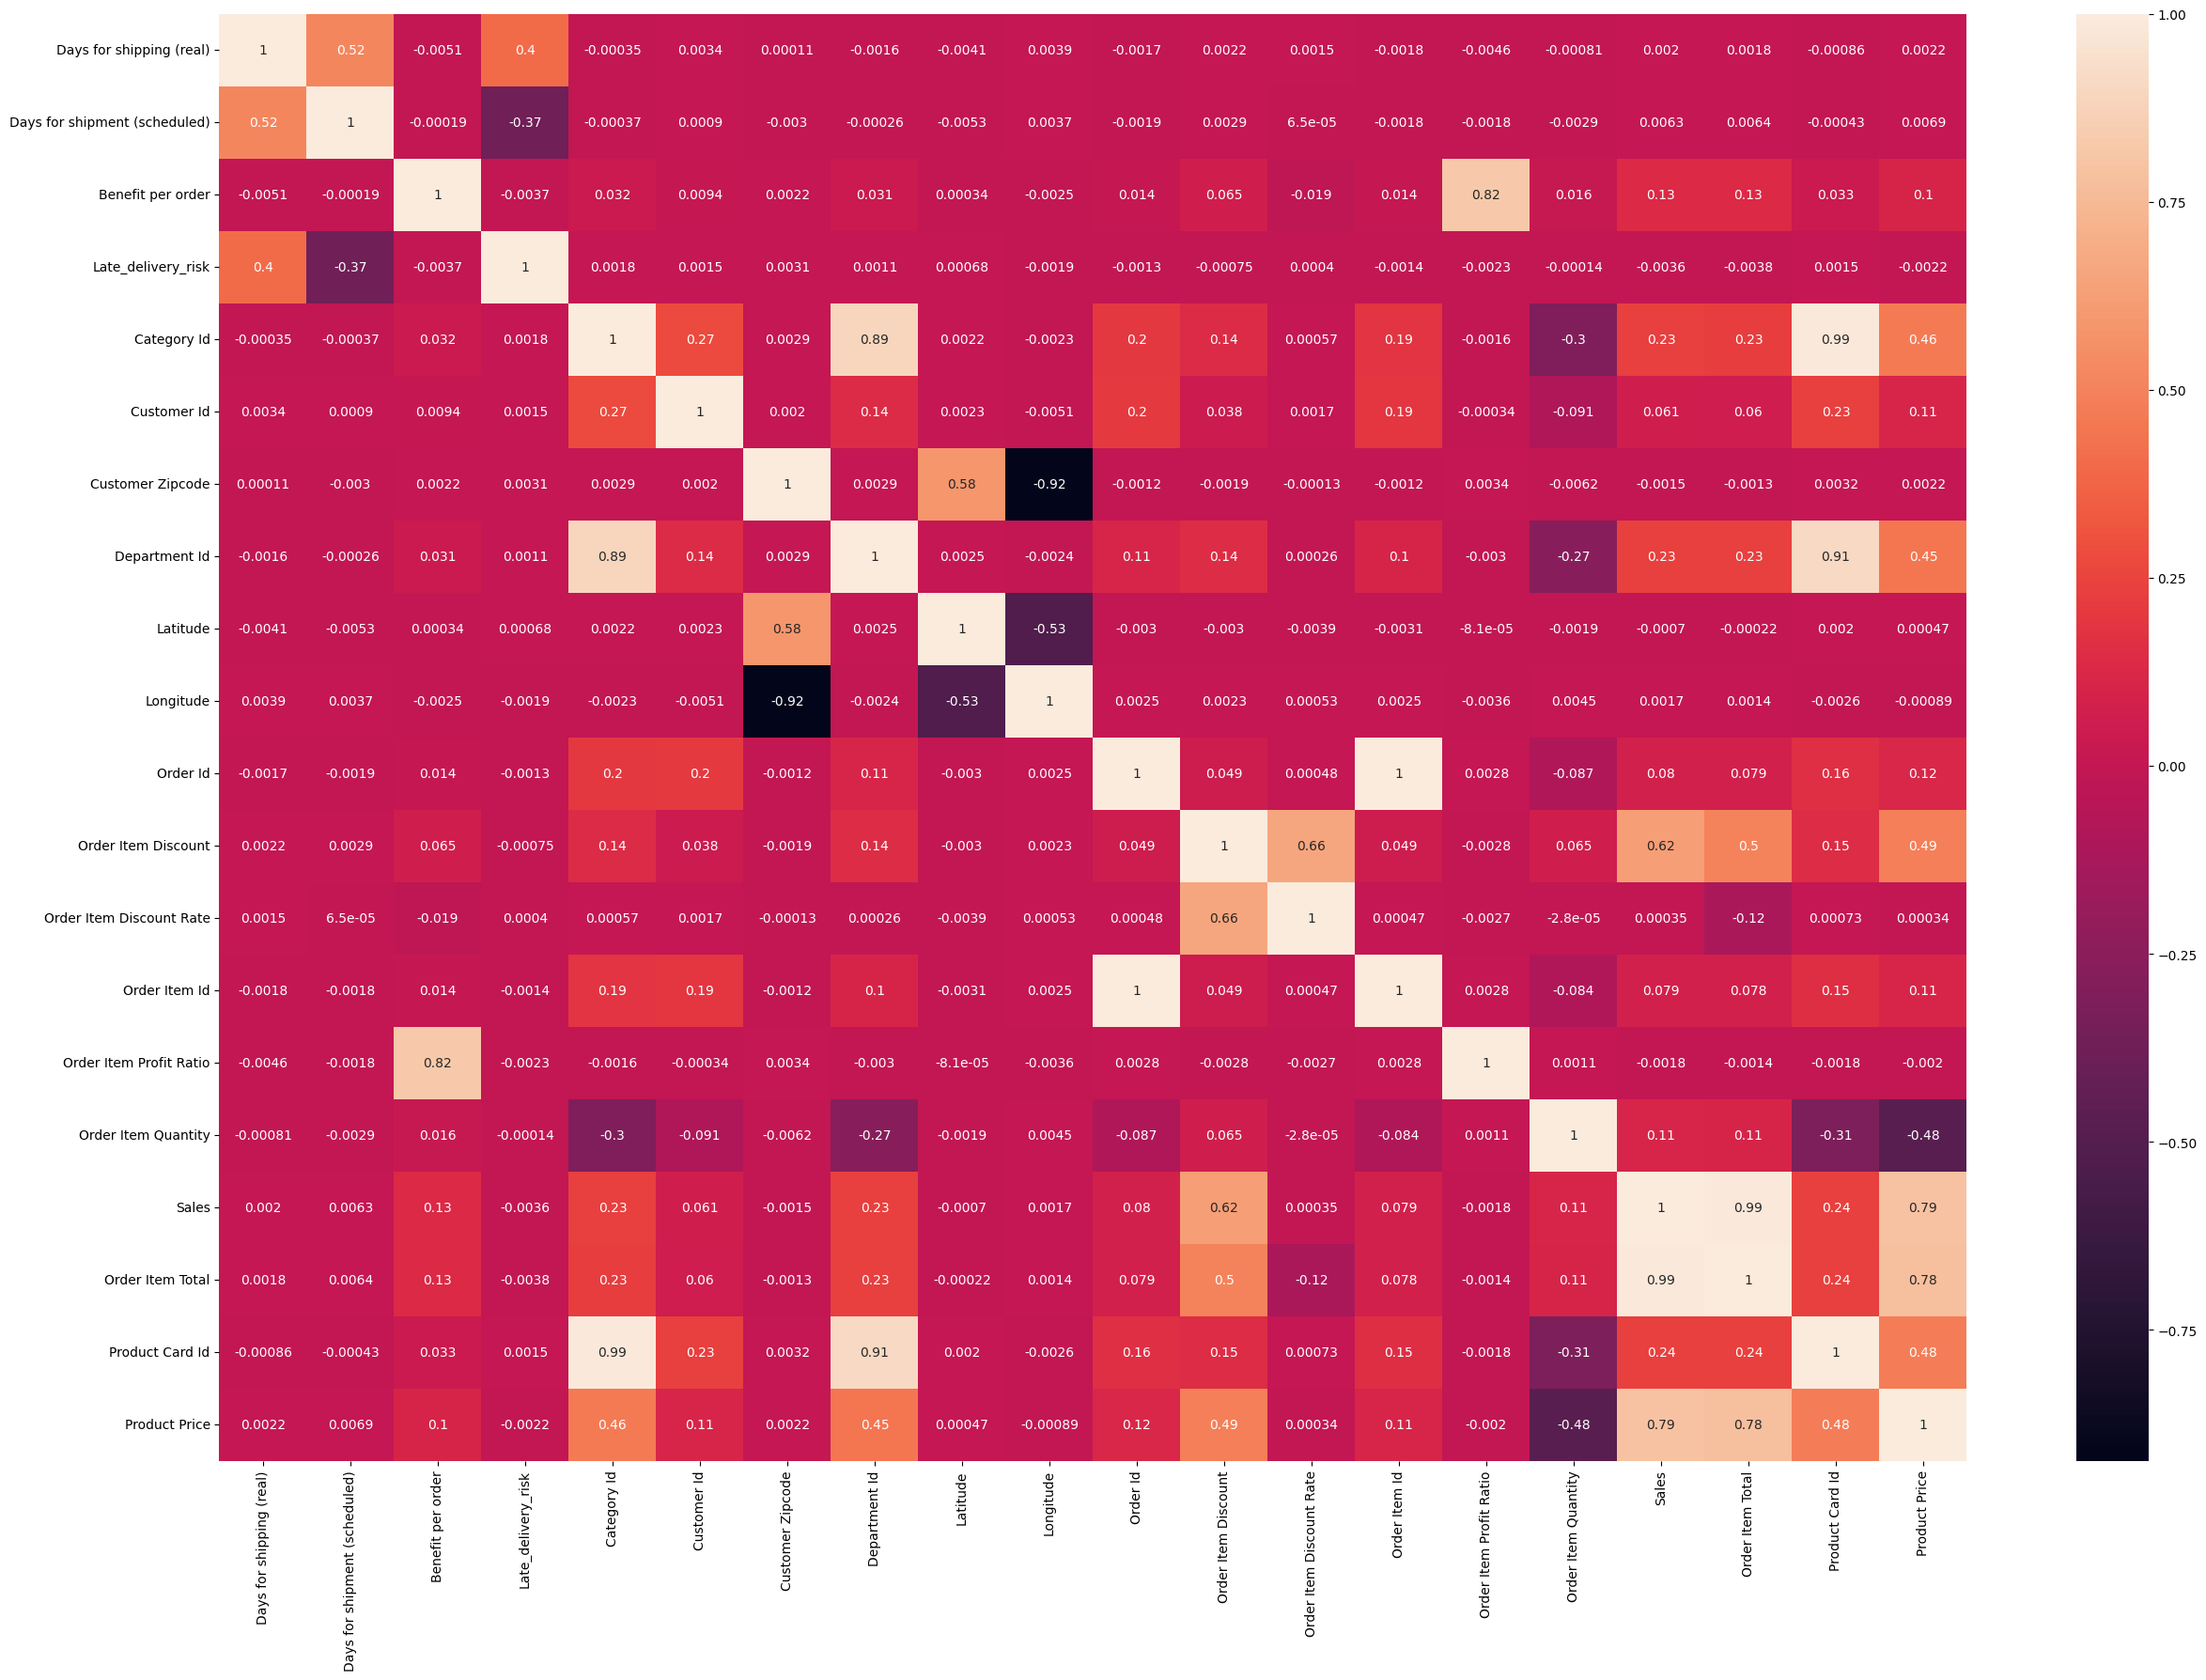

In [141]:
corrmap = df.corr()
top=corrmap.index
plt.figure(figsize=(30,20))
g=sns.heatmap(df[top].corr(),annot=True)

We can observe that Category Id and Product Card Id are highly correlated. They can be same values with different metadata.
Similarly, order id and order item id have correlation of 1. So, we can drop thise columns.

In [142]:
df.drop(['Category Id', 'Order Item Id', 'Order Item Profit Ratio'], axis=1, inplace=True)

0                             Type - no
1          Days for shipping (real)- s
2     Days for shipment (scheduled)- s
3                 Benefit per order- f
4                   Delivery Status- s
5                Late_delivery_risk- s
6                       Category Id- remove
7                     Category Name- p
8                     Customer City- c
9                  Customer Country- c
10                   Customer Fname- c
11                      Customer Id- c
12                   Customer Lname- c
13                 Customer Segment- c
14                   Customer State- c
15                  Customer Street- c
16                 Customer Zipcode- c
17                    Department Id- d
18                  Department Name- d
19                         Latitude- no
20                        Longitude- no
21                           Market- o
22                       Order City- o
23                    Order Country- o
24          order date (DateOrders)- o
25                         Order Id- o
26              Order Item Discount- f
27         Order Item Discount Rate- f
28                    Order Item Id- remove
29          Order Item Profit Ratio- remove
30              Order Item Quantity- f
31                            Sales- f
32                 Order Item Total- f
33                     Order Region- o
34                      Order State- o
35                     Order Status- o
36                  Product Card Id- p
37                     Product Name- p
38                    Product Price- p
39       shipping date (DateOrders)- s
40                    Shipping Mode- s

In [143]:
# Converting order date to date-time type
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'])

In [144]:
# Converting shipping date to date-time type
df['shipping date (DateOrders)'] = pd.to_datetime(df['shipping date (DateOrders)'])

In [145]:
df['order_year'] = pd.DatetimeIndex(df['order date (DateOrders)']).year
df['order_month'] = pd.DatetimeIndex(df['order date (DateOrders)']).month
df['order_date'] = pd.DatetimeIndex(df['order date (DateOrders)']).date

In [146]:
df['shipping_year'] = pd.DatetimeIndex(df['shipping date (DateOrders)']).year
df['shipping_month'] = pd.DatetimeIndex(df['shipping date (DateOrders)']).month
df['shipping_date'] = pd.DatetimeIndex(df['shipping date (DateOrders)']).date

In [147]:
# Renaming columns to standardize naming format
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df = df.rename(columns={
    'days_for_shipping_(real)': 'days_for_shipping',
    'days_for_shipment_(scheduled)': 'days_for_shipment',
})

In [148]:
df.drop(['order_date_(dateorders)', 'shipping_date_(dateorders)'], axis=1, inplace=True)

In [149]:
df['sales_id'] = df.index+1

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   type                      180519 non-null  object 
 1   days_for_shipping         180519 non-null  int64  
 2   days_for_shipment         180519 non-null  int64  
 3   benefit_per_order         180519 non-null  float64
 4   delivery_status           180519 non-null  object 
 5   late_delivery_risk        180519 non-null  int64  
 6   category_name             180519 non-null  object 
 7   customer_city             180519 non-null  object 
 8   customer_country          180519 non-null  object 
 9   customer_fname            180519 non-null  object 
 10  customer_id               180519 non-null  int64  
 11  customer_lname            180511 non-null  object 
 12  customer_segment          180519 non-null  object 
 13  customer_state            180519 non-null  o

In [152]:
file_path = r'C:\Users\srush\ETL-Analytics\data\cleanedDataset.csv'   # Specifying the path and file name
df.to_csv(file_path, index=False) 

# Data Modeling

![image](images\sc_datamodel.png)

### Creating Dim_Product table

In [116]:
dim_product = df[['product_card_id', 'product_name', 'product_price', 'category_name']].reset_index(drop=True)

In [118]:
dim_product['p_id'] = dim_product.index+1
dim_product = dim_product[['p_id','product_card_id', 'product_name', 'product_price', 'category_name']]
dim_product.head()

,p_id,product_card_id,product_name,product_price,category_name
0,1,1360,Smart watch,327.75,Sporting Goods
1,2,1360,Smart watch,327.75,Sporting Goods
2,3,1360,Smart watch,327.75,Sporting Goods
3,4,1360,Smart watch,327.75,Sporting Goods
4,5,1360,Smart watch,327.75,Sporting Goods


### Creating Dim_Order table

In [119]:
dim_order = df[['order_id', 'order_date', 'order_month', 'order_year','order_status','order_city','order_state','order_country','order_region','market']].reset_index(drop=True)
dim_order['o_id'] = dim_order.index+1
dim_order=dim_order[['o_id','order_id', 'order_date', 'order_month', 'order_year','order_status','order_city','order_state','order_country','order_region','market']]
dim_order.head()

,o_id,order_id,order_date,order_month,order_year,order_status,order_city,order_state,order_country,order_region,market
0,1,77202,2018-01-31,1,2018,COMPLETE,Bekasi,Java Occidental,Indonesia,Southeast Asia,Pacific Asia
1,2,75939,2018-01-13,1,2018,PENDING,Bikaner,Rajastán,India,South Asia,Pacific Asia
2,3,75938,2018-01-13,1,2018,CLOSED,Bikaner,Rajastán,India,South Asia,Pacific Asia
3,4,75937,2018-01-13,1,2018,COMPLETE,Townsville,Queensland,Australia,Oceania,Pacific Asia
4,5,75936,2018-01-13,1,2018,PENDING_PAYMENT,Townsville,Queensland,Australia,Oceania,Pacific Asia


### Creating Dim_Department table

In [120]:
dim_department = df[['department_id', 'department_name']].reset_index(drop=True)
dim_department['d_id'] = dim_department.index+1
dim_department = dim_department[['d_id','department_id', 'department_name']]
dim_department.head()

,d_id,department_id,department_name
0,1,2,Fitness
1,2,2,Fitness
2,3,2,Fitness
3,4,2,Fitness
4,5,2,Fitness


### Creating Dim_Customer table

In [121]:
dim_customer = df[['customer_id','customer_fname','customer_lname','customer_segment','customer_state','customer_city','customer_street','customer_zipcode','customer_country']].reset_index(drop=True)
dim_customer['c_id'] = dim_customer.index+1
dim_customer = dim_customer[['c_id','customer_id','customer_fname','customer_lname','customer_segment','customer_state','customer_city','customer_street','customer_zipcode','customer_country']]
dim_customer.head()

,c_id,customer_id,customer_fname,customer_lname,customer_segment,customer_state,customer_city,customer_street,customer_zipcode,customer_country
0,1,20755,Cally,Holloway,Consumer,PR,Caguas,5365 Noble Nectar Island,725.0,Puerto Rico
1,2,19492,Irene,Luna,Consumer,PR,Caguas,2679 Rustic Loop,725.0,Puerto Rico
2,3,19491,Gillian,Maldonado,Consumer,CA,San Jose,8510 Round Bear Gate,95125.0,EE. UU.
3,4,19490,Tana,Tate,Home Office,CA,Los Angeles,3200 Amber Bend,90027.0,EE. UU.
4,5,19489,Orli,Hendricks,Corporate,PR,Caguas,8671 Iron Anchor Corners,725.0,Puerto Rico


### Creating Dim_Shipping table

In [123]:
dim_shipping = df[['shipping_date','shipping_month','shipping_year','shipping_mode','days_for_shipping','days_for_shipment','delivery_status','late_delivery_risk']].reset_index(drop=True)
dim_shipping['s_id'] = dim_shipping.index+1
dim_shipping=dim_shipping[['s_id','shipping_date','shipping_month','shipping_year','shipping_mode','days_for_shipping','days_for_shipment','delivery_status','late_delivery_risk' ]]
dim_shipping.head()

,s_id,shipping_date,shipping_month,shipping_year,shipping_mode,days_for_shipping,days_for_shipment,delivery_status,late_delivery_risk
0,1,2018-02-03,2,2018,Standard Class,3,4,Advance shipping,0
1,2,2018-01-18,1,2018,Standard Class,5,4,Late delivery,1
2,3,2018-01-17,1,2018,Standard Class,4,4,Shipping on time,0
3,4,2018-01-16,1,2018,Standard Class,3,4,Advance shipping,0
4,5,2018-01-15,1,2018,Standard Class,2,4,Advance shipping,0


### Creating Fact_Sales table

In [126]:
raw_sales = df[['sales_id','sales', 'order_item_quantity','order_item_total','benefit_per_order','order_item_discount','order_item_discount_rate']].reset_index(drop=True)

In [128]:
fact_sales = raw_sales.merge(dim_product, left_on='sales_id', right_on='p_id') \
                        .merge(dim_order, left_on='sales_id', right_on='o_id') \
                        .merge(dim_department, left_on='sales_id', right_on='d_id') \
                        .merge(dim_customer, left_on='sales_id', right_on='c_id') \
                        .merge(dim_shipping, left_on='sales_id', right_on='s_id') \
                        [['sales_id','c_id','p_id','o_id','d_id','s_id','sales', 'order_item_quantity','order_item_total','benefit_per_order','order_item_discount','order_item_discount_rate']]

In [129]:
fact_sales.head()

,sales_id,c_id,p_id,o_id,d_id,s_id,sales,order_item_quantity,order_item_total,benefit_per_order,order_item_discount,order_item_discount_rate
0,1,1,1,1,1,1,327.75,1,314.640015,91.250000,13.110000,0.04
1,2,2,2,2,2,2,327.75,1,311.359985,-249.089996,16.389999,0.05
2,3,3,3,3,3,3,327.75,1,309.720001,-247.779999,18.030001,0.06
3,4,4,4,4,4,4,327.75,1,304.809998,22.860001,22.940001,0.07
4,5,5,5,5,5,5,327.75,1,298.250000,134.210007,29.500000,0.09
